# Case Study: InvertiaDB
## Temperature & IR Hairpin Distribution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from collections import defaultdict
from tqdm import tqdm

In [3]:
import os
from pathlib import Path
import numpy as np
from dotenv import load_dotenv

load_dotenv("paths.env")
DATABASE = os.getenv("DATABASE")
IRP_DB = os.getenv("IRP_DB")
EMPTY_ASSEMBLIES_PATH = os.getenv("EMPTY_ASSEMBLIES")

# assert os.path.isdir(DATABASE), "Invalid directory!"
assert os.path.isfile(IRP_DB), "Invalid inverted repeats database."
assert os.path.isfile(EMPTY_ASSEMBLIES_PATH), "Invalid empty assemblies db."

In [4]:
dest = Path("tempura_IR_analysis")
dest.mkdir(exist_ok=True)

In [5]:
empty_accessions = pl.read_csv(EMPTY_ASSEMBLIES_PATH, has_header=False, separator="\t", new_columns=["#assembly_accession"])\
            .with_columns(
                pl.col("#assembly_accession").map_elements(lambda seq: '_'.join(seq.split("/")[-1].split('_')[:2]), return_dtype=str)
            )
empty_accessions = list(empty_accessions["#assembly_accession"])
len(empty_accessions)

33119

In [6]:
irp_df = pl.read_parquet(IRP_DB)
print(irp_df.shape)
irp_df = irp_df.filter( (pl.col("spacerLength") <= 8) & (pl.col("armLength") >= 10))
print(irp_df.shape)

(29777220, 16)
(29589132, 16)


In [7]:
irp_df['spacerLength'].max(), irp_df['armLength'].min()

(8, 10)

In [8]:
tree_of_life = pl.read_csv("/storage/group/izg5139/default/nicole/minditool/mindi/design.csv", separator=",")
tree_of_life

accession_id,accession,organism_name,group,genome_size,genus,gc_percent,family,order,class,phylum,kingdom,superkingdom
str,str,str,str,i64,str,f64,str,str,str,str,str,str
"""GCF_000002515.2""","""/storage/group/izg5139/default…","""Kluyveromyces lactis""","""fungi""",10689156,"""Kluyveromyces""",0.39,"""Saccharomycetaceae""","""Saccharomycetales""","""Saccharomycetes""","""Ascomycota""","""Fungi""","""Eukaryota"""
"""GCF_000002725.2""","""/storage/group/izg5139/default…","""Leishmania major strain Friedl…","""protozoa""",32855089,"""Leishmania""",0.595,"""Trypanosomatidae""","""Trypanosomatida""","""Kinetoplastea""","""Euglenozoa""",null,"""Eukaryota"""
"""GCF_000002765.6""","""/storage/group/izg5139/default…","""Plasmodium falciparum 3D7""","""protozoa""",23292622,"""Plasmodium""",0.195,"""Plasmodiidae""","""Haemosporida""","""Aconoidasida""","""Apicomplexa""",null,"""Eukaryota"""
"""GCF_000002985.6""","""/storage/group/izg5139/default…","""Caenorhabditis elegans""","""invertebrate""",100272607,"""Caenorhabditis""",0.355,"""Rhabditidae""","""Rhabditida""","""Chromadorea""","""Nematoda""","""Metazoa""","""Eukaryota"""
"""GCF_000005825.2""","""/storage/group/izg5139/default…","""Alkalihalophilus pseudofirmus …","""bacteria""",4249248,"""Alkalihalophilus""",0.4,"""Bacillaceae""","""Bacillales""","""Bacilli""","""Bacillota""","""Bacillati""","""Bacteria"""
…,…,…,…,…,…,…,…,…,…,…,…,…
"""GCF_000219725.1""","""/storage/group/izg5139/default…","""Gracilinema caldarium DSM 7334""","""bacteria""",3239340,"""Gracilinema""",0.455,"""Breznakiellaceae""","""Spirochaetales""","""Spirochaetia""","""Spirochaetota""","""Pseudomonadati""","""Bacteria"""
"""GCF_000847005.1""","""/storage/group/izg5139/default…","""Gallid alphaherpesvirus 1""","""viral""",148687,"""Iltovirus""",0.48,"""Orthoherpesviridae""","""Herpesvirales""","""Herviviricetes""","""Peploviricota""","""Heunggongvirae""","""Viruses"""
"""GCF_000847605.1""","""/storage/group/izg5139/default…","""Equine infectious anemia virus""","""viral""",8359,"""Lentivirus""",0.385,"""Retroviridae""","""Ortervirales""","""Revtraviricetes""","""Artverviricota""","""Pararnavirae""","""Viruses"""


In [9]:
extract_id = lambda accession: '_'.join(Path(accession).name.split('_')[:2])

files = {extract_id(file): file for file in Path("/storage/group/izg5139/default/nicole/mindi/irp_out_no_eukaryotes/IR_extracted_accessions").glob("*.csv")}

In [10]:
len(files)

118072

In [11]:
assemblies = pl.read_csv("/storage/group/izg5139/default/ncbi_database/complete_accessions/filtered_assemblies_2024_3_22.txt",
                        separator="\t",
                        has_header=False)\
            .with_columns(
                pl.col("column_1").map_elements(lambda x: "_".join(x.split("/")[-1].split("_")[:2]), return_dtype=str).alias("#assembly_accession")
            )
assemblies_ids = dict(zip(assemblies["#assembly_accession"], assemblies["column_1"]))


summary = pl.read_csv("/storage/group/izg5139/default/ncbi_database/complete_accessions/assembly_summary.txt", 
                        null_values=['na', 'NA'],
                        has_header=False, 
                    separator="\t")\
                        .rename({"column_1": "#assembly_accession",
                               "column_27": "genome_size",
                               "column_28": "gc_percent",
                               "column_6": "taxid",
                               "column_7": "species_taxid",
                        })
summary

#assembly_accession,column_2,column_3,column_4,column_5,taxid,species_taxid,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,genome_size,gc_percent,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38
str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,f64,i64,i64,i64,str,str,str,i64,i64,i64,str
"""GCF_000762265.1""","""PRJNA224116""","""SAMN03085433""",null,null,2162,2162,"""Methanobacterium formicicum""","""strain=BRM9""",null,"""latest""","""Complete Genome""","""Major""","""Full""","""2014/10/02""","""ASM76226v1""","""PGgRc""","""GCA_000762265.1""","""identical""","""https://ftp.ncbi.nlm.nih.gov/g…",null,null,null,"""haploid""","""archaea""",2449987,2449987,41.5,1,1,1,"""NCBI RefSeq""","""NCBI Prokaryotic Genome Annota…","""2024/02/11""",2445,2386,55,null
"""GCF_001458655.1""","""PRJNA224116""","""SAMEA2779801""",null,"""representative genome""",2162,2162,"""Methanobacterium formicicum""",null,"""Mb9""","""latest""","""Complete Genome""","""Major""","""Full""","""2015/11/16""","""Mb9""","""CEBITEC""","""GCA_001458655.1""","""identical""","""https://ftp.ncbi.nlm.nih.gov/g…",null,null,null,"""haploid""","""archaea""",2494510,2494510,41.0,1,1,1,"""NCBI RefSeq""","""NCBI Prokaryotic Genome Annota…","""2024/02/12""",2462,2404,55,null
"""GCF_002813085.1""","""PRJNA224116""","""SAMN05935551""",null,null,2173,2173,"""Methanobrevibacter smithii""","""strain=KB11""",null,"""latest""","""Complete Genome""","""Major""","""Full""","""2017/12/06""","""ASM281308v1""","""KRIBB""","""GCA_002813085.1""","""identical""","""https://ftp.ncbi.nlm.nih.gov/g…",null,null,null,"""haploid""","""archaea""",1805545,1805545,31.0,1,1,1,"""NCBI RefSeq""","""NCBI Prokaryotic Genome Annota…","""2024/02/19""",1782,1715,43,null
"""GCF_022846155.1""","""PRJNA224116""","""SAMD00389909""",null,null,2173,2173,"""Methanobrevibacter smithii""","""strain=CE91-St67""",null,"""latest""","""Complete Genome""","""Major""","""Full""","""2022/02/04""","""ASM2284615v1""","""Laboratory for Microbiome Scie…","""GCA_022846155.1""","""identical""","""https://ftp.ncbi.nlm.nih.gov/g…",null,null,null,"""haploid""","""archaea""",1791153,1791153,31.0,1,1,1,"""NCBI RefSeq""","""NCBI Prokaryotic Genome Annota…","""2023/04/21""",1738,1680,44,null
"""GCF_022846175.1""","""PRJNA224116""","""SAMD00389910""",null,null,2173,2173,"""Methanobrevibacter smithii""","""strain=CE91-St68""",null,"""latest""","""Complete Genome""","""Major""","""Full""","""2022/02/04""","""ASM2284617v1""","""Laboratory for Microbiome Scie…","""GCA_022846175.1""","""identical""","""https://ftp.ncbi.nlm.nih.gov/g…",null,null,null,"""haploid""","""archaea""",1791155,1791155,31.0,1,1,1,"""NCBI RefSeq""","""NCBI Prokaryotic Genome Annota…","""2023/04/21""",1739,1681,44,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""GCA_037114785.1""",null,null,null,null,3127874,3127874,"""Enterococcus phage vB_Efa_ZAT1""",null,null,"""latest""","""Complete Genome""","""Major""","""Full""","""2024/03/06""","""ASM3711478v1""","""Pharmaceutical Microbiology an…",null,null,"""https://ftp.ncbi.nlm.nih.gov/g…",null,null,null,"""haploid""","""viral""",42928,42928,35.0,1,1,1,"""Pharmaceutical Microbiology an…","""Annotation submitted by Pharma…","""2024/03/11""",null,null,null,null
"""GCA_037114795.1""",null,null,null,null,3127946,3127946,"""Bacillus phage vB_Bsu_hmny1""",null,null,"""latest""","""Complete Genome""","""Major""","""Full""","""2024/03/06""","""ASM3711479v1""","""Food Science and Engineering, …",null,null,"""https://ftp.ncbi.nlm.nih.gov/g…",null,null,null,"""haploid""","""viral""",18740,18740,37.5,1,1,1,"""Food Science and Engineering, …","""Annotation submitted by Food S…","""2024/03/11""",null,null,null,null
"""GCA_037114805.1""",null,null,null,null,312

# Load Tempura DB

In [21]:
tempura_DB = pl.read_csv("/storage/group/izg5139/default/nicole/200617_TEMPURA.csv.gz")
tempura_DB

genus_and_species,taxonomy_id,strain,superkingdom,phylum,class,order,family,genus,assembly_or_accession,Genome_GC,Genome_size,16S_accssion,16S_GC,Tmin,Topt_ave,Topt_low,Topt_high,Tmax,Tmax_Tmin
str,i64,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
"""Methanopyrus kandleri""",2320,"""116""","""Archaea""","""Euryarchaeota""","""Methanopyri""","""Methanopyrales""","""Methanopyraceae""","""Methanopyrus""",null,null,null,"""AB301476""",67.7,85.0,100.0,null,null,122.0,37.0
"""""Geogemma barossii""""",1927912,"""121""","""Archaea""","""Crenarchaeota""","""Thermoprotei""","""Desulfurococcales""","""Pyrodictiaceae""","""Geogemma""",null,null,null,null,null,85.0,106.0,null,null,121.0,36.0
"""Pyrolobus fumarii""",54252,"""1A""","""Archaea""","""Crenarchaeota""","""Thermoprotei""","""Desulfurococcales""","""Pyrodictiaceae""","""Pyrolobus""","""GCA_000223395.1""",54.9,1.8,"""X99555""",68.4,90.0,106.0,null,null,113.0,23.0
"""Pyrococcus kukulkanii""",1609559,"""NCB100""","""Archaea""","""Euryarchaeota""","""Thermococci""","""Thermococcales""","""Thermococcaceae""","""Pyrococcus""","""GCA_001577775.1""",44.6,2.0,"""CP010835""",66.5,70.0,105.0,null,null,112.0,42.0
"""Methanopyrus kandleri""",2320,"""AV19""","""Archaea""","""Euryarchaeota""","""Methanopyri""","""Methanopyrales""","""Methanopyraceae""","""Methanopyrus""","""GCA_000007185.1""",61.2,1.7,"""NR_074539""",68.1,84.0,98.0,null,null,110.0,38.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Moritella profunda""",111291,"""2674""","""Bacteria""","""Proteobacteria""","""Gammaproteobacteria""","""Alteromonadales""","""Moritellaceae""","""Moritella""",null,41.4,null,"""AJ252023""",52.9,2.0,2.0,null,null,12.0,10.0
"""Lacinutrix jangbogonensis""",1469557,"""PAMC 27137""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavobacteriaceae""","""Lacinutrix""",null,32.1,null,"""KF977035""",49.5,4.0,10.0,null,null,10.0,6.0
"""Desulfofaba gelida""",84981,"""PSv29""","""Bacteria""","""Proteobacteria""","""Deltaproteobacteria""","""Desulfobacterales""","""Desulfobacteraceae""","""Desulfofaba""",null,52.8,null,"""AF099063""",52.9,-2.0,7.0,null,null,10.0,11.8


In [22]:
tempura_DB["assembly_or_accession"].is_null().sum()

7577

In [23]:
def classify(temp):
    if temp < 20:
        return "Psychrophiles"
    if temp < 45:
        return "Mesophiles"
    if temp < 80:
        return "Thermophiles"
    return "Hyperthermophiles"
    
    
tempura_DB_merged = tempura_DB.join(
                            summary.select(["#assembly_accession", "taxid", "species_taxid", "genome_size", "gc_percent"]), 
                                    left_on="taxonomy_id", 
                                    right_on="species_taxid", 
                                    how="inner"
                                )\
                        .with_columns(
                                    pl.col("Topt_ave").map_elements(classify, return_dtype=str)
                                   .alias("thermo_class")
                        )\
                    .filter(pl.col("superkingdom") == "Bacteria")
print(tempura_DB_merged["thermo_class"].value_counts())
tempura_DB_merged

shape: (4, 2)
┌───────────────────┬───────┐
│ thermo_class      ┆ count │
│ ---               ┆ ---   │
│ str               ┆ u32   │
╞═══════════════════╪═══════╡
│ Mesophiles        ┆ 6753  │
│ Thermophiles      ┆ 504   │
│ Psychrophiles     ┆ 107   │
│ Hyperthermophiles ┆ 30    │
└───────────────────┴───────┘


genus_and_species,taxonomy_id,strain,superkingdom,phylum,class,order,family,genus,assembly_or_accession,Genome_GC,Genome_size,16S_accssion,16S_GC,Tmin,Topt_ave,Topt_low,Topt_high,Tmax,Tmax_Tmin,#assembly_accession,taxid,genome_size,gc_percent,thermo_class
str,i64,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,f64,str
"""Myxococcus xanthus""",34,"""FB""","""Bacteria""","""Proteobacteria""","""Deltaproteobacteria""","""Myxococcales""","""Myxococcaceae""","""Myxococcus""","""GCA_000012685.1""",68.9,9.1,"""AB218205""",56.0,25.0,29.0,26.0,32.0,35.0,10.0,"""GCF_006402735.1""",34,9316447,69.0,"""Mesophiles"""
"""Myxococcus xanthus""",34,"""FB""","""Bacteria""","""Proteobacteria""","""Deltaproteobacteria""","""Myxococcales""","""Myxococcaceae""","""Myxococcus""","""GCA_000012685.1""",68.9,9.1,"""AB218205""",56.0,25.0,29.0,26.0,32.0,35.0,10.0,"""GCF_006401215.1""",34,9262965,69.0,"""Mesophiles"""
"""Myxococcus xanthus""",34,"""FB""","""Bacteria""","""Proteobacteria""","""Deltaproteobacteria""","""Myxococcales""","""Myxococcaceae""","""Myxococcus""","""GCA_000012685.1""",68.9,9.1,"""AB218205""",56.0,25.0,29.0,26.0,32.0,35.0,10.0,"""GCF_006400955.1""",34,9321034,69.0,"""Mesophiles"""
"""Myxococcus xanthus""",34,"""FB""","""Bacteria""","""Proteobacteria""","""Deltaproteobacteria""","""Myxococcales""","""Myxococcaceae""","""Myxococcus""","""GCA_000012685.1""",68.9,9.1,"""AB218205""",56.0,25.0,29.0,26.0,32.0,35.0,10.0,"""GCF_006401635.1""",34,8952969,69.0,"""Mesophiles"""
"""Myxococcus xanthus""",34,"""FB""","""Bacteria""","""Proteobacteria""","""Deltaproteobacteria""","""Myxococcales""","""Myxococcaceae""","""Myxococcus""","""GCA_000012685.1""",68.9,9.1,"""AB218205""",56.0,25.0,29.0,26.0,32.0,35.0,10.0,"""GCF_006402415.1""",34,9316378,69.0,"""Mesophiles"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Capnocytophaga endodontalis""",2708117,"""ChDC OS43""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavobacteriaceae""","""Capnocytophaga""","""GCA_002209445.1""",38.2,3.4,"""NR_165677""",50.9,30.0,35.0,null,null,40.0,10.0,"""GCA_002209445.1""",2708117,3412686,38.0,"""Mesophiles"""
"""Salaquimonas pukyongi""",2712698,"""RR3-28""","""Bacteria""","""Proteobacteria""","""Alphaproteobacteria""","""Rhizobiales""","""Phyllobacteriaceae""","""Salaquimonas""","""GCA_001953055.1""",58.6,3.4,"""MG889584""",55.1,20.0,27.5,25.0,30.0,35.0,15.0,"""GCA_001953055.1""",2712698,3357577,58.5,"""Mesophiles"""
"""Acaryochloris marina""",155978,"""MBIC11017""","""Bacteria""","""Cyanobacteria""",null,"""Synechococcales""","""Acaryochloridaceae""","""Acaryochloris""","""GCA_000018105.1""",47.0,8.4,"""AB058298""",54.7,20.0,29.0,28.0,30.0,35.0,15.0,"""GCA_018336915.1""",2762553,7112772,47.0,"""Mesophiles"""


In [15]:
accessions = list(set(tempura_DB_merged['#assembly_accession']))

In [24]:
filtered = {}
extract_id = lambda accession: '_'.join(Path(accession).name.split('_')[:2])

with open("../mindi/filtered_assemblies_2024_3_22.txt", mode="r") as f:
    for line in f:
        line = line.split("\t")[0]
        filtered.update({extract_id(line): line})
        
len(filtered)

118102

In [25]:
# unique = set()
extract_unique_id = lambda accession: Path(accession).name.split('_')[1]# .split('.')[0]

In [26]:
all_assemblies = set()
for accession in accessions:
    if accession in filtered:
        all_assemblies.add(extract_id(accession))
print(len(all_assemblies))
all_assemblies = list(all_assemblies)

3894


In [27]:
len(accessions)

7394

In [28]:
# unique = set()
# remaining assemblies are actual duplicates
extract_unique_id = lambda accession: Path(accession).name.split('_')[1].split('.')[0]
remaining = set()
for accession in accessions:
    remaining.add(extract_unique_id(accession))
len(remaining)

3894

### Merge IR-DB with TEMPURA Database & Keep Only Bacteria

In [29]:
irp_df_tempura = irp_df.join(
                             tempura_DB_merged, 
                             left_on="#assembly_accession",
                             right_on="#assembly_accession", 
                             how="inner")
irp_df_tempura

index,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,#assembly_accession,genus_and_species,taxonomy_id,strain,superkingdom,phylum,class,order,family,genus,assembly_or_accession,Genome_GC,Genome_size,16S_accssion,16S_GC,Tmin,Topt_ave,Topt_low,Topt_high,Tmax,Tmax_Tmin,taxid,genome_size,gc_percent,thermo_class
i64,str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,str
0,"""AE017194.1""",1785,1813,"""acagtctatc""","""cacatgta""","""acagtctatccacatgtagatagactgt""",10,8,28,3,1,3,3,"""3A/3C/1G/3T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles"""
1,"""AE017194.1""",9064,9088,"""aagaggggagat""",""".""","""aagaggggagatatctcccctctt""",12,0,24,5,6,0,1,"""5A/0C/6G/1T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles"""
2,"""AE017194.1""",10867,10890,"""attgatgaac""","""gct""","""attgatgaacgctgttcatcaat""",10,3,23,4,2,1,3,"""4A/1C/2G/3T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles"""
3,"""AE017194.1""",14322,14352,"""aaaaacacaagtc""","""tttt""","""aaaaacacaagtcttttgacttgtgttttt""",13,4,30,8,1,3,1,"""8A/3C/1G/1T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles"""
4,"""AE017194.1""",20272,20304,"""aactcccgtccct""","""ttatat""","""aactcccgtccctttatatagggacgggag…",13,6,32,2,1,7,3,"""2A/7C/1G/3T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
462,"""NZ_OY843610.1""",4405625,4405653,"""aaaaatgcccac""","""tatt""","""aaaaatgcccactattgtgggcattttt""",12,4,28,6,1,4,1,"""6A/4C/1G/1T""","""GCF_963692985.1""","""Maribacter dokdonensis""",320912,"""DSW-8""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavobacteriaceae""","""Maribacter""",null,36.1,null,"""AY960749""",54.2,4.0,30.0,null,null,35.0,31.0,320912,4490751,36.0,"""Mesophiles"""
463,"""NZ_OY843610.1""",4454730,4454752,"""acctgcctgcc""",""".""","""acctgcctgccggcaggcaggt""",11,0,22,1,2,6,2,"""1A/6C/2G/2T""","""GCF_963692985.1""","""Maribacter dokdonensis""",320912,"""DSW-8""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavobacteriaceae""","""Maribacter""",null,36.1,null,"""AY960749""",54.2,4.0,30.0,null,null,35.0,31.0,320912,4490751,36.0,"""Mesophiles"""
464,"""NZ_OY843610.1""",4455903,4455923,"""cctgcctgcc""",""".""","""cctgcctgccggcaggcagg""",10,0,20,0,2,6,2,"""0A/6C/2G/2T""","""GCF_963692985.1""","""Maribacter dokdonensis""",320912,"""DSW-8""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavobacteriaceae""","""Maribacter""",null,36.1,null,"""AY960749""",54.2,4.0,30.0,null,null,35.0,31.0,320912,4490751,36.0,"""Mesophiles"""


In [30]:
tempura_DB_merged['thermo_class'].value_counts()

thermo_class,count
str,u32
"""Hyperthermophiles""",30
"""Psychrophiles""",107
"""Mesophiles""",6753
"""Thermophiles""",504


## IR Frequency (%) Spacer Length Distribution

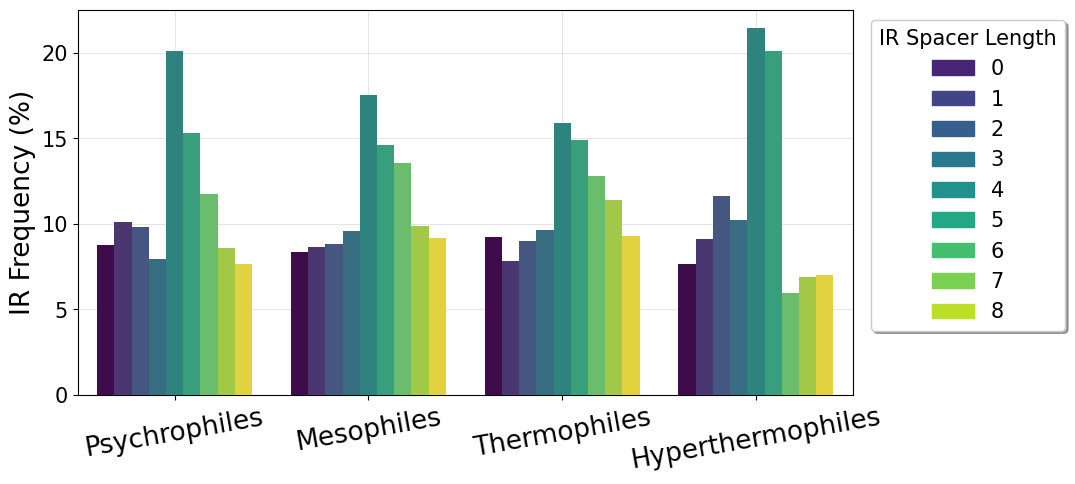

In [31]:
total_IR_per_class = irp_df_tempura.group_by("thermo_class", maintain_order=True)\
                            .agg(
                                pl.col("start").count().alias("IR_counts_global")
                            )


total_IR = irp_df_tempura.group_by(["thermo_class", "spacerLength"], maintain_order=True)\
                .agg(
                pl.col("start").count().alias("IR_counts"))\
                .join(
                        total_IR_per_class,
                        how="left",
                        on="thermo_class",
                )\
                .with_columns(
                                (pl.col("IR_counts") * 1e2 / pl.col("IR_counts_global")).alias("IR_perc")
)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5)) #, gridspec_kwargs={"wspace": 0.1})
# motifs_in_terminators["divergence"] = 100.0 - motifs_in_terminators["score"]
# compartments = ["Terminator", "Gene", "Promoter"]
thermo_class = ["Psychrophiles", "Mesophiles", "Thermophiles", "Hyperthermophiles"]

sns.barplot(
        data=total_IR,
        x="thermo_class",
        y="IR_perc",
        hue="spacerLength",
        capsize=.2,
        ax=ax,
        palette="viridis",
        order=thermo_class,
        # palette={"terminator": sns.color_palette("Set3")[2],
        #         "promoter": sns.color_palette("Set3")[0],
        #         "gene": sns.color_palette("Set3")[8]
        #        },
        zorder=3
)

colors = [cm.viridis(i) for i in np.arange(0.1, 1.1, 0.1)]
handles = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(9)]

ax.legend(title="IR Spacer Length", title_fontsize=15, handles=handles, prop={"size": 15}, fancybox=True, frameon=True, shadow=True, bbox_to_anchor=(1.01, 1.0))
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="both", labelsize=15)
ax.tick_params(axis="x", labelsize=19, rotation=10)
ax.set_ylabel("IR Frequency (%)")
ax.yaxis.label.set_size(19)
ax.set_xlabel('')
fig.savefig(f"{dest}/IR_percentage_thermo_class_spacer_length.png", bbox_inches='tight')

## IR Frequency (%) Arm Length Distribution

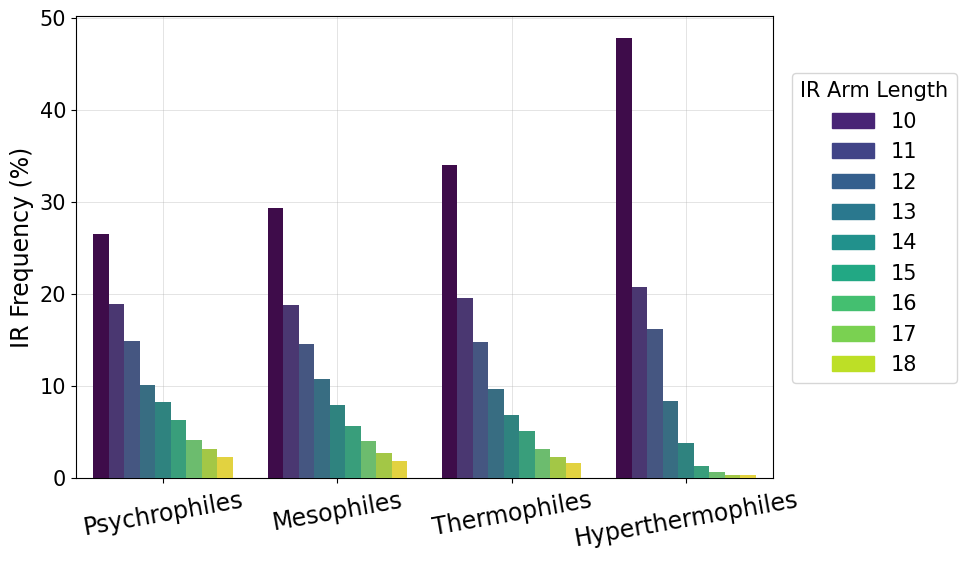

In [32]:

total_IR_per_class = irp_df_tempura.group_by("thermo_class", maintain_order=True).agg(pl.col("start").count().alias("IR_counts_global"))


total_IR = irp_df_tempura.group_by(["thermo_class", "armLength"], maintain_order=True)\
                .agg(pl.col("start").count().alias("IR_counts"))\
                .join(
                        total_IR_per_class,
                        how="left",
                        on="thermo_class",
                )\
                .with_columns(
                                (pl.col("IR_counts") * 1e2 / pl.col("IR_counts_global")).alias("IR_perc")
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
thermo_class = ["Psychrophiles", "Mesophiles", "Thermophiles", "Hyperthermophiles"]


colors = [cm.viridis(i) for i in np.arange(0.1, 1.0, 0.1)]
max_arm = 18
handles = [mpatches.Patch(color=colors[i], label=str(j)) for i, j in enumerate(range(10, max_arm+1))]

sns.barplot(
        data=total_IR.filter(pl.col("armLength") <= max_arm),
        x="thermo_class",
        y="IR_perc",
        hue="armLength",
        capsize=.2,
        ax=ax,
        palette="viridis",
        order=thermo_class,
        # palette={"terminator": sns.color_palette("Set3")[2],
        #         "promoter": sns.color_palette("Set3")[0],
        #         "gene": sns.color_palette("Set3")[8]
        #        },
        zorder=3
)
# ax.axhline(1.0, linestyle='--', lw=1.0, color='black', zorder=5)
ax.legend(title="IR Arm Length", 
          title_fontsize=15, 
          handles=handles, 
          prop={"size": 15}, 
          fancybox=True, 
          frameon=True, 
          bbox_to_anchor=(1.012, 0.9))
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="both", labelsize=15)
ax.tick_params(axis="x", labelsize=17, rotation=10)
ax.set_ylabel("IR Frequency (%)")
ax.yaxis.label.set_size(17)
ax.set_xlabel('')
fig.savefig(f"{dest}/IR_percentage_thermo_class_increasing_arm_length.png", bbox_inches='tight')

## IR Arm Sequence GC-Enrichment

In [33]:
total_IR_per_class = irp_df_tempura\
            .with_columns(
                    pl.col("gc_percent") / 1e2
            )

total_IR_per_class = total_IR_per_class\
            .with_columns(
                    pl.col("sequenceOfArm").map_elements(lambda seq: seq.count("g") + seq.count("c"),
                                                         return_dtype=int)
                    .alias("gc_arm_content"),
            )\
            .group_by(["#assembly_accession", "spacerLength"], 
                      maintain_order=True)\
                                  .agg(
                                      pl.col("gc_arm_content").sum(),
                                      pl.col("armLength").sum().alias("total_arm_length"),
                                      pl.col("gc_percent").first(),
                                      pl.col("thermo_class").first()
                                    )\
            .with_columns(
                        ((pl.col("gc_arm_content") / pl.col("total_arm_length")).alias("gc_content_ratio")
                        )
            )\
            .with_columns(
                       ( pl.col("gc_content_ratio") / pl.col("gc_percent"))
                    .alias("gc_arm_enrichment")
            )
                        

total_IR_per_class

#assembly_accession,spacerLength,gc_arm_content,total_arm_length,gc_percent,thermo_class,gc_content_ratio,gc_arm_enrichment
str,i64,i64,i64,f64,str,f64,f64
"""GCA_000008005.1""",8,643,1903,0.355,"""Mesophiles""",0.337888,0.951796
"""GCA_000008005.1""",0,400,1357,0.355,"""Mesophiles""",0.294768,0.830332
"""GCA_000008005.1""",3,645,1915,0.355,"""Mesophiles""",0.336815,0.948774
"""GCA_000008005.1""",4,1108,3338,0.355,"""Mesophiles""",0.331935,0.935029
"""GCA_000008005.1""",6,1038,3091,0.355,"""Mesophiles""",0.335814,0.945954
…,…,…,…,…,…,…,…
"""GCF_963692985.1""",0,237,723,0.36,"""Mesophiles""",0.327801,0.910558
"""GCF_963692985.1""",1,171,580,0.36,"""Mesophiles""",0.294828,0.818966
"""GCF_963692985.1""",4,399,1140,0.36,"""Mesophiles""",0.35,0.972222


/tmp/ipykernel_2089292/1684865589.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [cm.get_cmap("Spectral", lut=None).reversed()(i) for i in np.arange(0.1, 1.1, 0.1)]


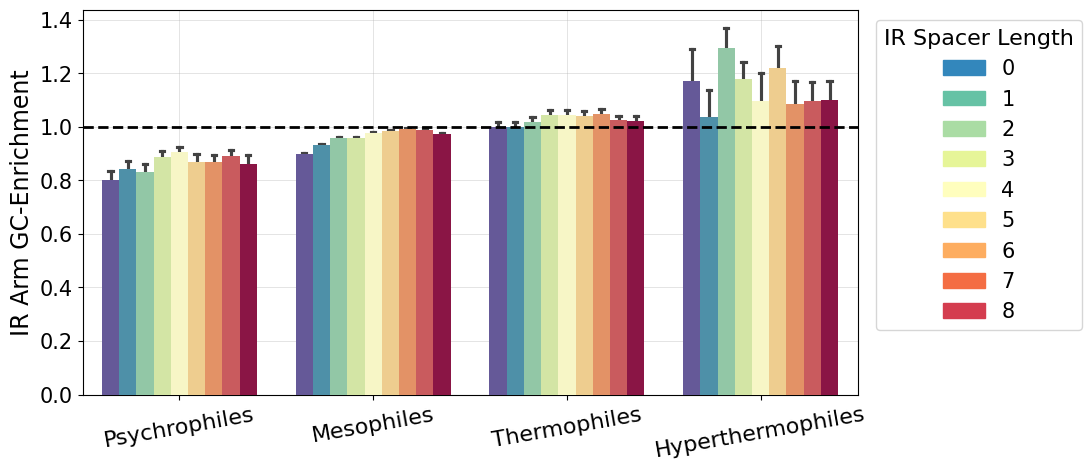

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
thermo_class = ["Psychrophiles", "Mesophiles", "Thermophiles", "Hyperthermophiles"]

sns.barplot(
        data=total_IR_per_class,
        x="thermo_class",
        y="gc_arm_enrichment",
        hue="spacerLength",
        capsize=.2,
        ax=ax,
        hue_order=list(range(9)),
        palette="Spectral_r",
        order=thermo_class,
        # palette={"terminator": sns.color_palette("Set3")[2],
        #         "promoter": sns.color_palette("Set3")[0],
        #         "gene": sns.color_palette("Set3")[8]
        #        },
        zorder=3
)



colors = [cm.get_cmap("Spectral", lut=None).reversed()(i) for i in np.arange(0.1, 1.1, 0.1)]
handles = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(9)]

ax.axhline(1.0, linestyle='--', lw=2.0, color='black', zorder=5)
ax.legend(title="IR Spacer Length", handles=handles, prop={"size": 15}, fancybox=True, frameon=True, 
          title_fontsize=16, bbox_to_anchor=(1.01, 1.0))
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="both", labelsize=15)
ax.tick_params(axis="x", labelsize=16, rotation=10)
ax.set_ylabel("IR Arm GC-Enrichment")
ax.yaxis.label.set_size(17)
ax.set_xlabel('')
fig.savefig(f"{dest}/IR_GC_enrichment_arm_thermo_class_avg.png", bbox_inches='tight')

## GC Spacer Sequence Enrichment

/tmp/ipykernel_2089292/2545803499.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [cm.get_cmap("Spectral", lut=None).reversed()(i) for i in np.arange(0.1, 1.1, 0.1)]


Text(0.5, 0, '')

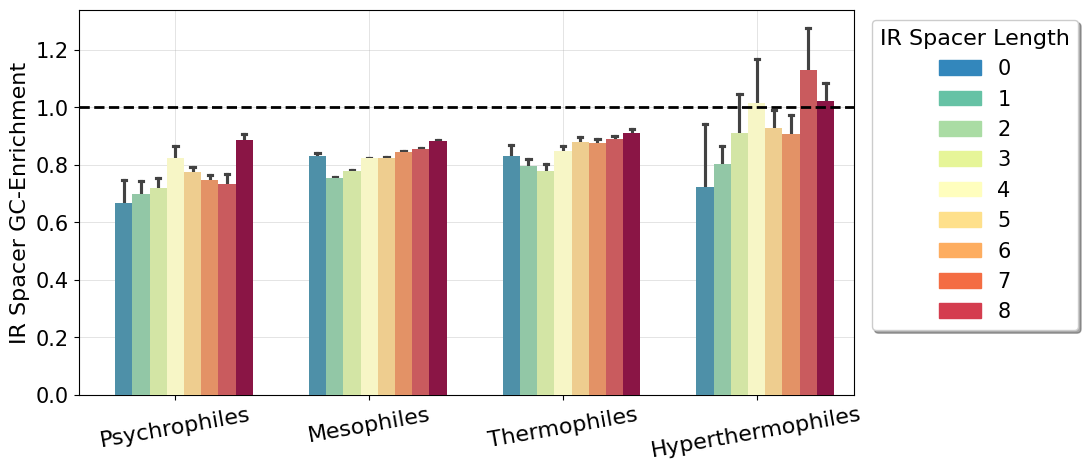

In [35]:
total_IR_per_class = irp_df_tempura\
            .with_columns(
                    pl.col("gc_percent") / 1e2
            )

total_IR_per_class = total_IR_per_class\
            .with_columns(
                    pl.col("sequenceOfSpacer").map_elements(lambda seq: seq.count("g") + seq.count("c"),
                                                         return_dtype=int)
                    .alias("gc_spacer_content"),
            )\
            .group_by(["#assembly_accession", "spacerLength"], 
                      maintain_order=True)\
                                  .agg(
                                      pl.col("gc_spacer_content").sum(),
                                      pl.col("spacerLength").sum().alias("total_spacer_length"),
                                      pl.col("gc_percent").first(),
                                      pl.col("thermo_class").first()
                                    )\
            .with_columns(
                        ((pl.col("gc_spacer_content") / pl.col("total_spacer_length")).alias("gc_content_ratio")
                        )
            )\
            .with_columns(
                       ( pl.col("gc_content_ratio") / pl.col("gc_percent"))
                    .alias("gc_spacer_enrichment")
            )
                        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
thermo_class = ["Psychrophiles", "Mesophiles", "Thermophiles", "Hyperthermophiles"]

sns.barplot(
        data=total_IR_per_class,
        x="thermo_class",
        y="gc_spacer_enrichment",
        hue="spacerLength",
        capsize=.2,
        ax=ax,
        palette="Spectral_r",
        order=thermo_class,
        hue_order=list(range(9)),
        zorder=3
)

colors = [cm.get_cmap("Spectral", lut=None).reversed()(i) for i in np.arange(0.1, 1.1, 0.1)]
handles = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(9)]

ax.axhline(1.0, linestyle='--', lw=2.0, color='black', zorder=5)
ax.legend(title="IR Spacer Length", 
          title_fontsize=16,
          handles=handles, 
          prop={"size": 15}, 
          fancybox=True, 
          frameon=True,
          shadow=True, 
          bbox_to_anchor=(1.01, 1.0))
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="both", labelsize=15)
ax.tick_params(axis="x", labelsize=16, rotation=10)
ax.set_ylabel("IR Spacer GC-Enrichment")
ax.yaxis.label.set_size(16)
ax.set_xlabel('')

In [36]:
irp_df_tempura.unique(["#assembly_accession"])["thermo_class"].value_counts()

thermo_class,count
str,u32
"""Mesophiles""",3563
"""Psychrophiles""",55
"""Thermophiles""",260
"""Hyperthermophiles""",15


In [37]:
irp_df_tempura.group_by("thermo_class", maintain_order=True)\
                .agg(
                            pl.col("armLength").max().alias("armLength_max"),
                            pl.col("armLength").min().alias("armLength_min"),
                            pl.col("spacerLength").max()
                )

thermo_class,armLength_max,armLength_min,spacerLength
str,i64,i64,i64
"""Mesophiles""",15727,10,8
"""Thermophiles""",62,10,8
"""Psychrophiles""",44,10,8
"""Hyperthermophiles""",22,10,8


In [38]:
irp_df_tempura.unique(["#assembly_accession"]).head()

index,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,#assembly_accession,genus_and_species,taxonomy_id,strain,superkingdom,phylum,class,order,family,genus,assembly_or_accession,Genome_GC,Genome_size,16S_accssion,16S_GC,Tmin,Topt_ave,Topt_low,Topt_high,Tmax,Tmax_Tmin,taxid,genome_size,gc_percent,thermo_class
i64,str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,str
0,"""NZ_CP040340.1""",52,75,"""cgagcttaat""","""ttt""","""cgagcttaattttattaagctcg""",10,3,23,3,2,2,3,"""3A/2C/2G/3T""","""GCF_009739965.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,1396,5856577,35.0,"""Mesophiles"""
0,"""NZ_CP102294.1""",14781,14818,"""cagtggaaggggagcgc""","""ata""","""cagtggaaggggagcgcatagcgctcccct…",17,3,37,4,9,3,1,"""4A/3C/9G/1T""","""GCF_025144665.1""","""Alistipes ihumii""",1470347,"""AP11""","""Bacteria""","""Bacteroidetes""","""Bacteroidia""","""Bacteroidales""","""Rikenellaceae""","""Alistipes""",null,57.9,null,"""JX101692""",53.4,25.0,37.0,null,null,45.0,20.0,1211813,2780015,58.0,"""Mesophiles"""
0,"""CP063443.1""",5456,5491,"""atacccccctaatt""","""aattcta""","""atacccccctaattaattctaaattagggg…",14,7,35,4,0,6,4,"""4A/6C/0G/4T""","""GCA_015169195.1""","""Staphylococcus haemolyticus""",1283,"""ATCC 29970""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Staphylococcaceae""","""Staphylococcus""","""GCA_000009865.1""",32.8,2.7,"""D83367""",51.4,18.0,35.0,30.0,40.0,45.0,27.0,1283,2771335,34.0,"""Mesophiles"""
0,"""NZ_CP045192.1""",834,867,"""tgattggattgca""","""taacttt""","""tgattggattgcataacttttgcaatccaa…",13,7,33,3,4,1,5,"""3A/1C/4G/5T""","""GCF_009362255.1""","""Tenacibaculum mesophilum""",104268,"""CIP107215""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavobacteriaceae""","""Tenacibaculum""",null,31.5,null,"""AB032501""",49.4,15.0,31.5,28.0,35.0,49.0,34.0,104268,3358580,32.0,"""Mesophiles"""
0,"""NZ_CP019705.1""",1029,1049,"""cagcgctgga""",""".""","""cagcgctggatccagcgctg""",10,0,20,2,4,3,1,"""2A/3C/4G/1T""","""GCF_002005245.1""","""Corynebacterium ammoniagenes""",1697,"""ATCC 6871""","""Bacteria""","""Actinobacteria""","""Actinobacteria""","""Corynebacteriales""","""Corynebacteriaceae""","""Corynebacterium""","""GCA_001941425.1""",55.5,2.8,"""X84440""",55.8,10.0,30.0,null,null,37.0,27.0,1697,2808265,55.5,"""Mesophiles"""


In [39]:
tempura_DB_merged["#assembly_accession"].is_null().sum()

0

In [40]:
# all_accessions = set(tempura_DB_merged["#assembly_accession"])
non_empty_accessions = set(irp_df_tempura.unique(["#assembly_accession"])["#assembly_accession"])

empty_accessions = set(all_assemblies) - non_empty_accessions
len(empty_accessions), len(non_empty_accessions)

(1, 3893)

In [41]:
empty_accessions

{'GCA_036812565.1'}

## IR Occurrences as function of GC-Content of the Arm

In [43]:
irp_df_tempura = irp_df_tempura.with_columns(
                pl.col("sequenceOfArm")
                .map_elements(lambda seq: (seq.count("g") + seq.count("c")) / len(seq), return_dtype=float)
                .alias("gc_arm")
)
irp_df_tempura

index,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,#assembly_accession,genus_and_species,taxonomy_id,strain,superkingdom,phylum,class,order,family,genus,assembly_or_accession,Genome_GC,Genome_size,16S_accssion,16S_GC,Tmin,Topt_ave,Topt_low,Topt_high,Tmax,Tmax_Tmin,taxid,genome_size,gc_percent,thermo_class,gc_arm
i64,str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,str,f64
0,"""AE017194.1""",1785,1813,"""acagtctatc""","""cacatgta""","""acagtctatccacatgtagatagactgt""",10,8,28,3,1,3,3,"""3A/3C/1G/3T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles""",0.4
1,"""AE017194.1""",9064,9088,"""aagaggggagat""",""".""","""aagaggggagatatctcccctctt""",12,0,24,5,6,0,1,"""5A/0C/6G/1T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles""",0.5
2,"""AE017194.1""",10867,10890,"""attgatgaac""","""gct""","""attgatgaacgctgttcatcaat""",10,3,23,4,2,1,3,"""4A/1C/2G/3T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles""",0.3
3,"""AE017194.1""",14322,14352,"""aaaaacacaagtc""","""tttt""","""aaaaacacaagtcttttgacttgtgttttt""",13,4,30,8,1,3,1,"""8A/3C/1G/1T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles""",0.307692
4,"""AE017194.1""",20272,20304,"""aactcccgtccct""","""ttatat""","""aactcccgtccctttatatagggacgggag…",13,6,32,2,1,7,3,"""2A/7C/1G/3T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles""",0.615385
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
462,"""NZ_OY843610.1""",4405625,4405653,"""aaaaatgcccac""","""tatt""","""aaaaatgcccactattgtgggcattttt""",12,4,28,6,1,4,1,"""6A/4C/1G/1T""","""GCF_963692985.1""","""Maribacter dokdonensis""",320912,"""DSW-8""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavobacteriaceae""","""Maribacter""",null,36.1,null,"""AY960749""",54.2,4.0,30.0,null,null,35.0,31.0,320912,4490751,36.0,"""Mesophiles""",0.416667
463,"""NZ_OY843610.1""",4454730,4454752,"""acctgcctgcc""",""".""","""acctgcctgccggcaggcaggt""",11,0,22,1,2,6,2,"""1A/6C/2G/2T""","""GCF_963692985.1""","""Maribacter dokdonensis""",320912,"""DSW-8""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavobacteriaceae""","""Maribacter""",null,36.1,null,"""AY960749""",54.2,4.0,30.0,null,null,35.0,31.0,320912,4490751,36.0,"""Mesophiles""",0.727273
464,"""NZ_OY843610.1""",4455903,4455923,"""cctgcctgcc""",""".""","""cctgcctgccggcaggcagg""",10,0,20,0,2,6,2,"""0A/6C/2G/2T""","""GCF_963692985.1""","""Maribacter dokdonensis""",320912,"""DSW-8""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavobacteriaceae""","""Maribacter""",null,36.1,null,"""AY960749""",54.2,4.0,30.0,null,null,35.0,31.0,320912,4490751,36.0,"""Mesophiles""",0.8


In [44]:
counts_per_thermo_class = irp_df_tempura\
                    .group_by("thermo_class", maintain_order=True)\
                    .agg(
                        pl.col("start")\
                        .count()\
                        .alias("total_counts")
                    )
counts_per_thermo_class = dict(zip(counts_per_thermo_class["thermo_class"], 
                                   counts_per_thermo_class["total_counts"]))
counts_per_thermo_class

{'Mesophiles': 2066992,
 'Thermophiles': 76527,
 'Psychrophiles': 27867,
 'Hyperthermophiles': 1762}

## Calculating Genome Sizes

In [47]:
counts = defaultdict(list)
IR_counts_collection = []

step = 0.05
thresholds = np.arange(0.0, 1 + step, step)

for threshold in thresholds:
    IR_counts = irp_df_tempura.filter(pl.col("gc_arm") >= threshold)\
                                .group_by("#assembly_accession", maintain_order=True)\
                                .agg(
                                        pl.col("start").count().alias("IR_counts"),
                                        pl.col("genome_size").first().alias("Genome Size"),
                                        pl.col("thermo_class").first()
                                )\
                                .with_columns(
                                        ( 1e6 * pl.col("IR_counts") / pl.col("Genome Size") ).alias("IR Density")
                                )
    
    bounded_non_empty = set(IR_counts.unique("#assembly_accession")["#assembly_accession"])

    # create new empty list on GC Threshold (strict)
    bounded_new_empty = set(all_assemblies) - bounded_non_empty
    print(f"Total empty accessions for GC threshold {threshold:.2f}: {len(bounded_new_empty)}")

    empty_assemblies_df = pl.DataFrame({"#assembly_accession": list(bounded_new_empty)})\
                            .join(
                                    tempura_DB_merged.select(["#assembly_accession", "genome_size", "thermo_class"]),
                                    on="#assembly_accession"
                            )\
                            .with_columns(
                                pl.lit(0).alias("IR Density").cast(pl.Float64),
                                pl.lit(0).alias("IR_counts").cast(pl.UInt32),
                                pl.col("genome_size").alias("Genome Size"),
                            )\
                            .select(["#assembly_accession", 
                                     "IR_counts", 
                                     "Genome Size", 
                                     "thermo_class", 
                                     "IR Density"])
    
    IR_counts_merged = pl.concat([IR_counts, empty_assemblies_df])\
                        .group_by("thermo_class", maintain_order=True)\
                        .agg(
                                pl.col("IR Density").mean().alias("avg_IR_density"),
                                pl.col("IR Density").std().alias("std_IR_density"),
                        )\
                        .with_columns(
                                pl.lit(threshold).alias("GC Threshold")
                        )

    IR_counts_collection.append(IR_counts_merged)
  
IR_counts_collection = pl.concat(IR_counts_collection, how="vertical")
IR_counts_collection

Total empty accessions for GC threshold 0.00: 1
Total empty accessions for GC threshold 0.05: 1
Total empty accessions for GC threshold 0.10: 1
Total empty accessions for GC threshold 0.15: 1
Total empty accessions for GC threshold 0.20: 1
Total empty accessions for GC threshold 0.25: 1
Total empty accessions for GC threshold 0.30: 1
Total empty accessions for GC threshold 0.35: 1
Total empty accessions for GC threshold 0.40: 1
Total empty accessions for GC threshold 0.45: 3
Total empty accessions for GC threshold 0.50: 8
Total empty accessions for GC threshold 0.55: 52
Total empty accessions for GC threshold 0.60: 321
Total empty accessions for GC threshold 0.65: 493
Total empty accessions for GC threshold 0.70: 859
Total empty accessions for GC threshold 0.75: 1121
Total empty accessions for GC threshold 0.80: 1194
Total empty accessions for GC threshold 0.85: 2028
Total empty accessions for GC threshold 0.90: 2035
Total empty accessions for GC threshold 0.95: 2425
Total empty access

thermo_class,avg_IR_density,std_IR_density,GC Threshold
str,f64,f64,f64
"""Mesophiles""",131.733715,62.600292,0.0
"""Thermophiles""",99.030185,37.86796,0.0
"""Psychrophiles""",128.037593,34.393905,0.0
"""Hyperthermophiles""",61.930758,25.478888,0.0
"""Mesophiles""",128.227308,58.814929,0.05
…,…,…,…
"""Hyperthermophiles""",0.0,0.0,0.95
"""Thermophiles""",2.772573,7.075708,1.0
"""Mesophiles""",1.562127,4.899084,1.0


In [50]:
order = [
      "Psychrophiles",
      "Mesophiles",
      "Thermophiles",
      "Hyperthermophiles",
]

palette = {
        "Psychrophiles": sns.color_palette("Set3")[4], 
         "Mesophiles": sns.color_palette("Set3")[2],
         "Thermophiles": sns.color_palette("Set3")[-1], 
         "Hyperthermophiles": sns.color_palette("Set3")[3],
}

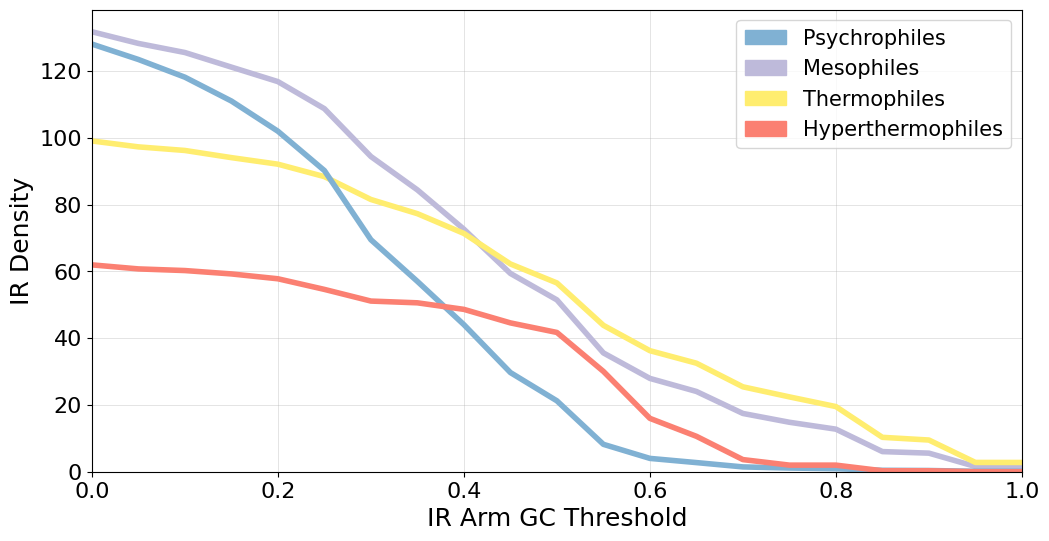

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

sns.lineplot(data=IR_counts_collection.to_pandas(),
             x="GC Threshold",
             y="avg_IR_density",
             hue="thermo_class",
            ax=ax,
             palette=palette,
            linewidth=4.0,
    )
handles = [mpatches.Patch(color=palette[label], label=label) for label in order]
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.legend(loc=0, handles=handles, title="", prop={"size": 15})
ax.set_xlabel("IR Arm GC Threshold")
ax.set_ylabel("IR Density")
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis="both", labelsize=16)
ax.set_xlim(xmin=0.0, xmax=1.0)
ax.set_ylim(ymin=0.0)
0.0
fig.savefig(f"{dest}/rolling_IR_density_gc_content_arm", bbox_inches="tight")

### Integrate with empty accessions

In [54]:
len(empty_accessions)

1

In [64]:
empty_assemblies_df = pl.DataFrame({"#assembly_accession": list(empty_accessions)})\
                        .join(
                                tempura_DB_merged.select(["#assembly_accession", "genome_size", "thermo_class"]),
                                on="#assembly_accession"
                        )\
                        .with_columns(
                            pl.lit(0).alias("IR Density").cast(pl.Float64),
                            pl.lit(0).alias("IR_counts").cast(pl.UInt32),
                            pl.col("genome_size").alias("Genome Size"),
                        )\
                        .select(["#assembly_accession", 
                                 "IR_counts", 
                                 "Genome Size", 
                                 "thermo_class", 
                                 "IR Density"
                                ])
empty_assemblies_df

#assembly_accession,IR_counts,Genome Size,thermo_class,IR Density
str,u32,i64,str,f64
"""GCA_036812565.1""",0,2929,"""Mesophiles""",0.0


In [56]:
IR_counts.unique("thermo_class")

#assembly_accession,IR_counts,Genome Size,thermo_class,IR Density
str,u32,i64,str,f64
"""GCA_000143165.1""",3,1686510,"""Mesophiles""",1.778821
"""GCF_003149515.1""",36,5027597,"""Psychrophiles""",7.160478
"""GCA_000010565.1""",2,3025375,"""Thermophiles""",0.661075


In [74]:
# merge with empty

IR_counts = irp_df_tempura.group_by("#assembly_accession", maintain_order=True)\
                        .agg(
                                    pl.col("start").count().alias("IR_counts"),
                                    pl.col("genome_size").first().alias("Genome Size"),
                                    pl.col("thermo_class").first(),
                        )\
                        .with_columns(
                                        (1e6 * pl.col("IR_counts") / pl.col("Genome Size")).alias("IR Density")
                        )
IR_counts_merged = pl.concat([IR_counts, empty_assemblies_df])

IR_counts_grouped = IR_counts_merged\
                .group_by("thermo_class", maintain_order=True)\
                .agg(
                    pl.col("IR Density").count().alias("Total Organismal Genomes"),
                    pl.col("IR Density").mean().round(2).alias("Average IR Density"),
                    pl.col("IR Density").median().round(2).alias("Median IR Density"),
                    pl.col("IR Density").quantile(0.95).round(2).alias("95 Percentile"),
                    pl.col("IR Density").quantile(0.05).round(2).alias("5 Percentile"),
                ).rename({"thermo_class": "Temperature Class"})
IR_counts_grouped

Temperature Class,Total Organismal Genomes,Average IR Density,Median IR Density,95 Percentile,5 Percentile
str,u32,f64,f64,f64,f64
"""Mesophiles""",3564,131.73,117.13,263.85,51.4
"""Thermophiles""",260,99.03,102.1,147.87,42.95
"""Psychrophiles""",55,128.04,136.57,195.58,68.02
"""Hyperthermophiles""",15,61.93,59.91,93.7,10.66


In [75]:
IR_counts_merged.group_by("thermo_class").agg(pl.col("IR Density").count().alias("counts"))

thermo_class,counts
str,u32
"""Psychrophiles""",55
"""Mesophiles""",3564
"""Hyperthermophiles""",15
"""Thermophiles""",260


In [76]:
IR_counts_merged.shape

(3894, 5)

In [77]:
IR_counts_merged.filter(pl.col("IR_counts") == 0).group_by("thermo_class").agg(pl.col("IR Density").count().alias("counts"))

thermo_class,counts
str,u32
"""Mesophiles""",1


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Psychrophiles vs. Mesophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:6.623e-01 t=-4.368e-01
Mesophiles vs. Thermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:1.283e-16 t=8.313e+00
Thermophiles vs. Hyperthermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:2.223e-04 t=3.742e+00
Psychrophiles vs. Thermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:2.943e-07 t=5.241e+00
Mesophiles vs. Hyperthermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:1.627e-05 t=4.317e+00
Psychrophiles vs. Hyperthermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:1.911e-09 t=6.928e+00


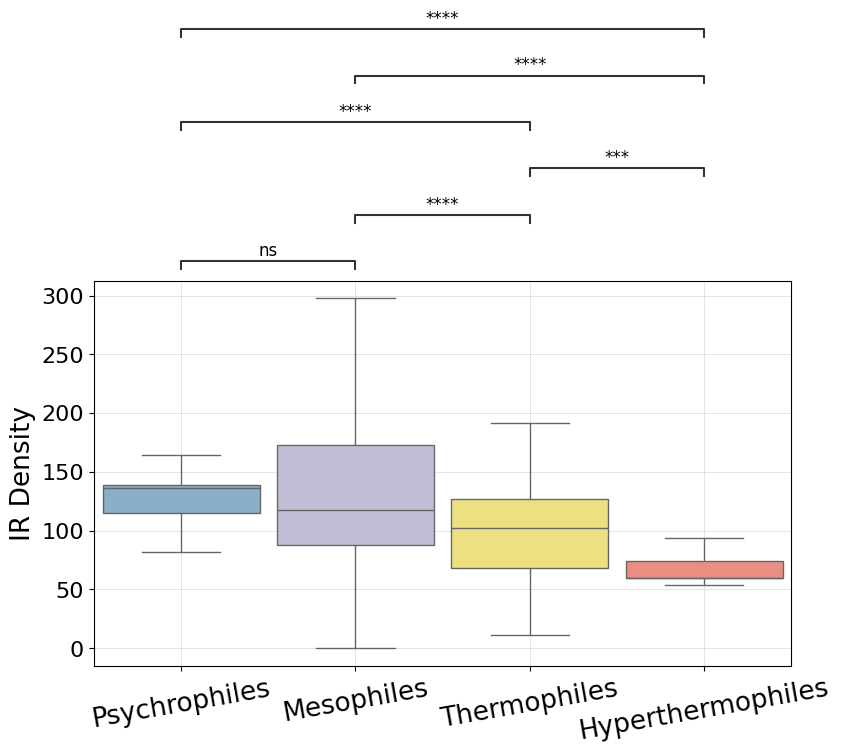

In [78]:
import matplotlib.patches as mpatches
from statannotations.Annotator import Annotator


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

order = [
      "Psychrophiles",
      "Mesophiles",
      "Thermophiles",
      "Hyperthermophiles",
]

sns.boxplot(data=IR_counts_merged,
             x="thermo_class",
             y="IR Density",
             hue="thermo_class",
            ax=ax,
            showfliers=False,
            width=0.9,
            palette=palette,
            # yerr=counts_df["symmetric_error"],
            # color="black",
            # linewidth=3.0,
            order=order,
    )
pairs = [
         ("Psychrophiles", "Thermophiles"), 
         ("Psychrophiles", "Mesophiles"),
         ("Psychrophiles", "Hyperthermophiles"),
         ("Mesophiles", "Thermophiles"),
         ("Mesophiles", "Hyperthermophiles"),
         ("Thermophiles", "Hyperthermophiles")
]
        
annotator = Annotator(ax, 
                      pairs=pairs, 
                      data=IR_counts_merged.to_pandas(), 
                      x="thermo_class",
                      hue="thermo_class", 
                      y="IR Density", 
                      order=order,
                      # hue_order=hue_order,
                     )
annotator.configure(test='t-test_ind', 
                    text_format='star',
                    fontsize=12, 
                    line_offset=0.0,
                    comparisons_correction="fdr_bh",
                    loc='outside')

ax.tick_params(axis="x", rotation=10, labelsize=17)
annotator.apply_and_annotate()
handles = [mpatches.Patch(color=palette[label], label=label) for label in order]
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.legend(loc=0, handles=handles, title="", prop={"size": 15})
ax.legend(handles=[], frameon=False)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(19)
ax.tick_params(axis="both", labelsize=16)
ax.tick_params(axis="x", labelsize=19, rotation=10)

ax.set_xlabel('')
fig.savefig(f"{dest}/thermo_class_IR_density_boxplot.png", bbox_inches="tight")

#### Anova Comparisons of IR Hairpin Densities across Temperature Classes

In [79]:
IR_counts_merged.head()

#assembly_accession,IR_counts,Genome Size,thermo_class,IR Density
str,u32,i64,str,f64
"""GCA_000008005.1""",1415,5432652,"""Mesophiles""",260.462109
"""GCA_000010565.1""",210,3025375,"""Thermophiles""",69.412883
"""GCA_000013065.1""",1464,5506207,"""Mesophiles""",265.881759
"""GCA_000021225.1""",1468,5599857,"""Mesophiles""",262.149551
"""GCA_000026125.1""",438,3424307,"""Mesophiles""",127.909092


In [80]:
IR_counts_merged.filter(pl.col("IR_counts") == 0)["thermo_class"].value_counts()

thermo_class,count
str,u32
"""Mesophiles""",1


In [81]:
from scipy.stats import f_oneway, kruskal

thermo_classes = list(IR_counts_merged.unique("thermo_class")["thermo_class"])
print(f"Total Temperature Classes from Tempura DB: {len(thermo_classes)}.")


samples_IR_densities_thermo_anova = []
for thermo_class in thermo_classes:
    print(thermo_class)
    IR_densities = list(IR_counts_merged.filter(pl.col("thermo_class") == thermo_class)["IR Density"])
    samples_IR_densities_thermo_anova.append(IR_densities)
    
print(f"\nTotal Temperature Classes for ANOVA: {len(samples_IR_densities_thermo_anova)}.\n")

anova = f_oneway(*samples_IR_densities_thermo_anova, nan_policy="raise")
print(f"One Way ANOVA comparison of Hairpin IR Densities across Temperature Classes:\n{anova}", end="\n" * 2)

kruskal_test = kruskal(*samples_IR_densities_thermo_anova, nan_policy="raise")
print(f"KRUSAL comparison of Hairpin IR Densities across Temperature Classes:\n{kruskal_test}.")

Total Temperature Classes from Tempura DB: 4.
Psychrophiles
Hyperthermophiles
Mesophiles
Thermophiles

Total Temperature Classes for ANOVA: 4.

One Way ANOVA comparison of Hairpin IR Densities across Temperature Classes:
F_onewayResult(statistic=29.474377691285852, pvalue=7.751566358550115e-19)

KRUSAL comparison of Hairpin IR Densities across Temperature Classes:
KruskalResult(statistic=84.73554811336669, pvalue=2.9574669642485412e-18).


## Percentage of IR counts

In [82]:
irp_df_tempura.head()

index,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,#assembly_accession,genus_and_species,taxonomy_id,strain,superkingdom,phylum,class,order,family,genus,assembly_or_accession,Genome_GC,Genome_size,16S_accssion,16S_GC,Tmin,Topt_ave,Topt_low,Topt_high,Tmax,Tmax_Tmin,taxid,genome_size,gc_percent,thermo_class,gc_arm
i64,str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,str,f64
0,"""AE017194.1""",1785,1813,"""acagtctatc""","""cacatgta""","""acagtctatccacatgtagatagactgt""",10,8,28,3,1,3,3,"""3A/3C/1G/3T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles""",0.4
1,"""AE017194.1""",9064,9088,"""aagaggggagat""",""".""","""aagaggggagatatctcccctctt""",12,0,24,5,6,0,1,"""5A/0C/6G/1T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles""",0.5
2,"""AE017194.1""",10867,10890,"""attgatgaac""","""gct""","""attgatgaacgctgttcatcaat""",10,3,23,4,2,1,3,"""4A/1C/2G/3T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles""",0.3
3,"""AE017194.1""",14322,14352,"""aaaaacacaagtc""","""tttt""","""aaaaacacaagtcttttgacttgtgttttt""",13,4,30,8,1,3,1,"""8A/3C/1G/1T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles""",0.307692
4,"""AE017194.1""",20272,20304,"""aactcccgtccct""","""ttatat""","""aactcccgtccctttatatagggacgggag…",13,6,32,2,1,7,3,"""2A/7C/1G/3T""","""GCA_000008005.1""","""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,222523,5432652,35.5,"""Mesophiles""",0.615385


In [83]:
from collections import defaultdict
counts = defaultdict(list)

irp_df_tempura = irp_df_tempura.with_columns(
        pl.col("sequenceOfArm").map_elements(lambda seq: (seq.count('g') + seq.count('c'))/len(seq),
                                                                                  return_dtype=float).alias("gc_arm")
                                            )

for threshold in tqdm(np.arange(0.0, 1.1, 0.02)):
    
    IR_counts = irp_df_tempura.filter(pl.col("gc_arm") >= threshold)["thermo_class"].value_counts()
    IR_counts = dict(zip(IR_counts["thermo_class"], IR_counts["count"]))
    
    for c, total_counts in IR_counts.items():
        counts["threshold"].append(threshold)
        counts["thermo_class"].append(c)
        counts["counts"].append(total_counts)
        counts["total"].append(counts_per_thermo_class[c])
        
counts_df  = pl.DataFrame(counts)\
            .with_columns(
                        (1e2 * pl.col("counts") / pl.col("total")).alias("IR_perc")
            )
counts_df

100%|██████████| 55/55 [00:09<00:00,  5.60it/s]


threshold,thermo_class,counts,total,IR_perc
f64,str,i64,i64,f64
0.0,"""Hyperthermophiles""",1762,1762,100.0
0.0,"""Thermophiles""",76527,76527,100.0
0.0,"""Psychrophiles""",27867,27867,100.0
0.0,"""Mesophiles""",2066992,2066992,100.0
0.02,"""Hyperthermophiles""",1732,1762,98.297389
…,…,…,…,…
0.98,"""Psychrophiles""",36,27867,0.129185
0.98,"""Mesophiles""",32525,2066992,1.573543
1.0,"""Thermophiles""",2093,76527,2.734982


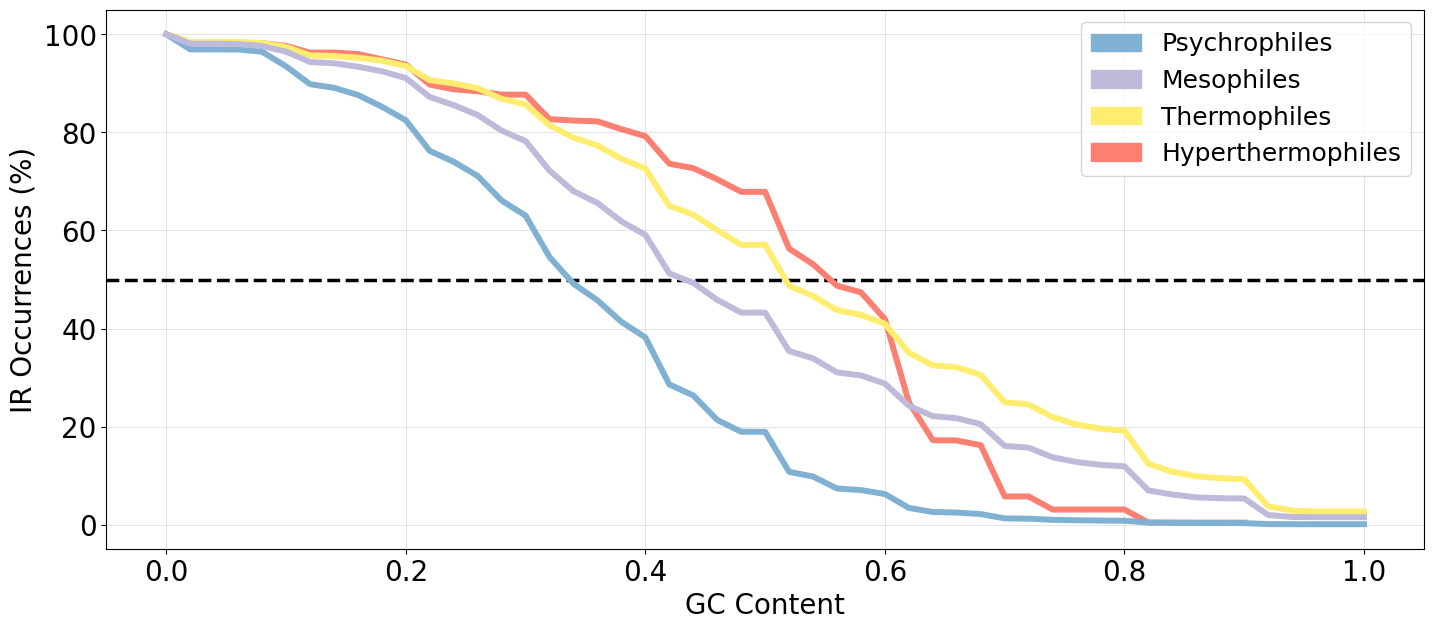

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 7))

sns.lineplot(data=counts_df.to_pandas(),
             x="threshold",
             y="IR_perc",
             hue="thermo_class",
             palette=palette,
             zorder=3,
             lw=4.3,
             ax=ax
            )
handles = [mpatches.Patch(color=palette[label], label=label) for label in order]
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="both", labelsize=20, zorder=0)
ax.legend(handles=handles, loc=0, title="", prop={"size": 18})
ax.set_xlabel("GC Content")
ax.axhline(50.0, linestyle='--', color='black', lw=2.5, zorder=2.0)
ax.set_ylabel("IR Occurrences (%)")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
fig.savefig(f"{dest}/IR_occurrences_perc_vs_arm_gc_content.png", bbox_inches='tight')

### IR Density vs Thermo Class

In [85]:
empty_accessions_df = pl.DataFrame({"#assembly_accession": list(empty_accessions)})\
                    .join(
                            tempura_DB_merged.select(["#assembly_accession", "genome_size", "thermo_class"]),
                            on="#assembly_accession",
                    )\
                    .with_columns(
                                pl.lit(0).alias("IR Counts"),
                                pl.lit(0).alias("IR Density").cast(pl.Float64),
                    )
empty_accessions_df

#assembly_accession,genome_size,thermo_class,IR Counts,IR Density
str,i64,str,i32,f64
"""GCA_036812565.1""",2929,"""Mesophiles""",0,0.0


In [88]:
irp_df_tempura_grped = irp_df_tempura.group_by("#assembly_accession")\
                .agg(
                    pl.col("genome_size").first(),
                     pl.col("thermo_class").first(),
                    pl.col("start").count().alias("IR Counts").cast(pl.Int32),
                   )\
            .with_columns(
                        (pl.col("IR Counts") * 1e6 / pl.col("genome_size")).alias("IR Density")
        )

irp_df_tempura_grped = pl.concat([irp_df_tempura_grped, empty_accessions_df])
irp_df_tempura_grped

#assembly_accession,genome_size,thermo_class,IR Counts,IR Density
str,i64,str,i32,f64
"""GCF_001679705.1""",3074042,"""Mesophiles""",554,180.218748
"""GCF_000763575.1""",2397824,"""Thermophiles""",307,128.03275
"""GCF_014844495.1""",3221293,"""Mesophiles""",438,135.970245
"""GCF_034043435.1""",2708221,"""Mesophiles""",362,133.667083
"""GCF_002215175.1""",5721108,"""Mesophiles""",1532,267.780297
…,…,…,…,…
"""GCF_000020525.1""",3293456,"""Mesophiles""",273,82.891649
"""GCF_029718665.1""",6236239,"""Mesophiles""",623,99.899956
"""GCF_035578885.1""",6740460,"""Mesophiles""",639,94.800652


### Arm GC Enrichment vs Thermo Class

In [90]:
total_gc_content = irp_df_tempura.with_columns(
                                    pl.col("sequenceOfArm")
                                    .map_elements(lambda seq: seq.count("g") + seq.count("c"), return_dtype=int)
                        .alias("gc_arm")
)\
        .group_by("#assembly_accession", maintain_order=True)\
        .agg(
             pl.col("gc_arm").sum(),
             pl.col("armLength").sum(),
             pl.col("gc_percent").first(),
             pl.col("genome_size").first(),
             pl.col("family").first(),
             pl.col("order").first(),
             pl.col("Topt_ave").first(),
             pl.col("superkingdom").first(),
             pl.col("phylum").first(),
             pl.col("armLength").max().alias("maximum_arm"),
             pl.col("armLength").mean().alias("avg_arm_size")
            )\
        .with_columns(
                    (pl.col("gc_arm") / pl.col("armLength")).alias("gc_arm_perc"),
                    pl.col("gc_percent") / 1e2,
                    pl.col("Topt_ave").map_elements(classify, return_dtype=str).alias("thermo_class"),
        )\
        .with_columns(
                   ( pl.col("gc_arm_perc") / pl.col("gc_percent") ).alias("hairpin_gc_enrichment"),
        )
total_gc_content

#assembly_accession,gc_arm,armLength,gc_percent,genome_size,family,order,Topt_ave,superkingdom,phylum,maximum_arm,avg_arm_size,gc_arm_perc,thermo_class,hairpin_gc_enrichment
str,i64,i64,f64,i64,str,str,f64,str,str,i64,f64,f64,str,f64
"""GCA_000008005.1""",6318,19337,0.355,5432652,"""Bacillaceae""","""Bacillales""",37.0,"""Bacteria""","""Firmicutes""",33,13.665724,0.326731,"""Mesophiles""",0.920369
"""GCA_000010565.1""",1161,2328,0.53,3025375,"""Peptococcaceae""","""Clostridiales""",55.0,"""Bacteria""","""Firmicutes""",22,11.085714,0.498711,"""Thermophiles""",0.940965
"""GCA_000013065.1""",6396,19842,0.355,5506207,"""Bacillaceae""","""Bacillales""",37.0,"""Bacteria""","""Firmicutes""",27,13.553279,0.322347,"""Mesophiles""",0.908018
"""GCA_000021225.1""",6401,19729,0.355,5599857,"""Bacillaceae""","""Bacillales""",37.0,"""Bacteria""","""Firmicutes""",27,13.439373,0.324446,"""Mesophiles""",0.913933
"""GCA_000026125.1""",2668,5467,0.545,3424307,"""Oxalobacteraceae""","""Burkholderiales""",25.0,"""Bacteria""","""Proteobacteria""",24,12.481735,0.488019,"""Mesophiles""",0.895448
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""GCF_963677905.1""",1349,3037,0.465,4831792,"""Prolixibacteraceae""","""Marinilabiliales""",33.0,"""Bacteria""","""Bacteroidetes""",22,12.245968,0.444188,"""Mesophiles""",0.955244
"""GCF_963682195.1""",1117,2064,0.525,4204558,"""Spirochaetaceae""","""Spirochaetales""",32.5,"""Bacteria""","""Spirochaetes""",24,11.595506,0.541182,"""Mesophiles""",1.030823
"""GCF_963691725.1""",2548,5620,0.45,4670665,"""Alteromonadaceae""","""Alteromonadales""",33.5,"""Bacteria""","""Proteobacteria""",22,11.516393,0.453381,"""Mesophiles""",1.007513


In [91]:
from scipy.stats import f_oneway, kruskal

thermo_classes = list(total_gc_content.unique("thermo_class")["thermo_class"])
print(f"Total Temperature Classes from Tempura DB: {len(thermo_classes)}.")

samples_thermo_anova = []
for thermo_class in thermo_classes:
    print(thermo_class)
    gc_enrichment = list(total_gc_content.filter(pl.col("thermo_class") == thermo_class)["hairpin_gc_enrichment"])
    samples_thermo_anova.append(gc_enrichment)
    
print(f"Total Temperature Classes for ANOVA: {len(samples_thermo_anova)}.")

anova = f_oneway(*samples_thermo_anova, nan_policy="raise")
print(f"One Way ANOVA comparison of Hairpin IR Arm GC-Enrichment across Temperature Classes:\n{anova}")

kruskal_test = kruskal(*samples_thermo_anova, nan_policy="raise")
print(f"KRUSAL comparison of Hairpin IR Arm GC-Enrichment across Temperature Classes:\n{kruskal_test}.")


Total Temperature Classes from Tempura DB: 4.
Mesophiles
Thermophiles
Hyperthermophiles
Psychrophiles
Total Temperature Classes for ANOVA: 4.
One Way ANOVA comparison of Hairpin IR Arm GC-Enrichment across Temperature Classes:
F_onewayResult(statistic=56.938315475313736, pvalue=5.140108353196395e-36)
KRUSAL comparison of Hairpin IR Arm GC-Enrichment across Temperature Classes:
KruskalResult(statistic=137.55885145461866, pvalue=1.2699385225181544e-29).


In [92]:
f_oneway(*samples_thermo_anova, nan_policy="raise"), kruskal(*samples_thermo_anova, nan_policy="raise")

(F_onewayResult(statistic=56.938315475313736, pvalue=5.140108353196395e-36),
 KruskalResult(statistic=137.55885145461866, pvalue=1.2699385225181544e-29))

In [93]:
tempura_DB_merged.group_by("thermo_class", maintain_order=True)\
            .agg(pl.col("phylum").n_unique())

thermo_class,phylum
str,u32
"""Mesophiles""",19
"""Thermophiles""",20
"""Hyperthermophiles""",3
"""Psychrophiles""",4


In [95]:
total_gc_content.group_by("thermo_class", maintain_order=True)\
            .agg(
                pl.col("hairpin_gc_enrichment").mean().alias("gc_enrichment_mean"),
                pl.col("hairpin_gc_enrichment").median().alias("gc_enrichment_median")
                )

thermo_class,gc_enrichment_mean,gc_enrichment_median
str,f64,f64
"""Mesophiles""",0.96755,0.956488
"""Thermophiles""",1.034056,1.031581
"""Psychrophiles""",0.865352,0.867992
"""Hyperthermophiles""",1.14978,1.177086


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Psychrophiles vs. Mesophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:2.226e-11 t=-6.712e+00
Mesophiles vs. Thermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:7.121e-20 t=-9.176e+00
Thermophiles vs. Hyperthermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:3.634e-04 t=-3.611e+00
Psychrophiles vs. Thermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:1.852e-20 t=-9.954e+00
Mesophiles vs. Hyperthermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:4.386e-10 t=-6.257e+00
Psychrophiles vs. Hyperthermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:1.075e-13 t=-9.276e+00


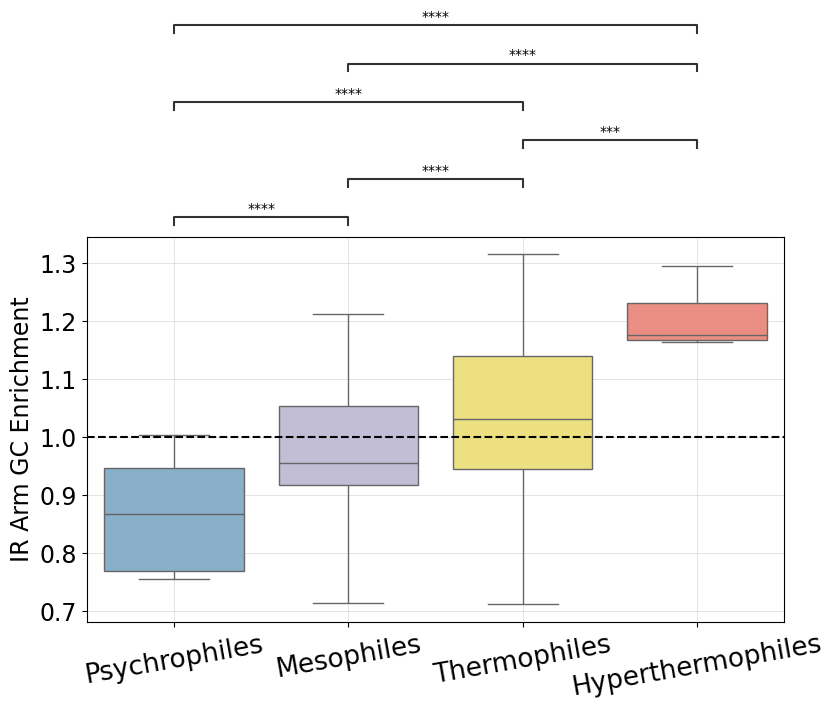

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

order = [
      "Psychrophiles",
      "Mesophiles",
      "Thermophiles",
      "Hyperthermophiles",
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
sns.boxplot(data=total_gc_content.to_pandas(), 
            x="thermo_class", 
            hue="thermo_class",
            y="hairpin_gc_enrichment",
            showfliers=False,
            palette=palette,
            order=order,
            ax=ax)
    
pairs = [
         ("Psychrophiles", "Thermophiles"), 
         ("Psychrophiles", "Mesophiles"),
         ("Psychrophiles", "Hyperthermophiles"),
         ("Mesophiles", "Thermophiles"),
         ("Mesophiles", "Hyperthermophiles"),
         ("Thermophiles", "Hyperthermophiles")
]
        
annotator = Annotator(ax, 
                      pairs=pairs, 
                      data=total_gc_content.to_pandas(), 
                      x="thermo_class",
                      hue="thermo_class", 
                      y="hairpin_gc_enrichment", 
                      order=order,
                      # hue_order=hue_order,
                     )
annotator.configure(test='t-test_ind', 
                    text_format='star',
                    fontsize=10,
                    comparisons_correction="fdr_bh",
                    loc='outside'
                   )
annotator.apply_and_annotate()
ax.axhline(1.0, linestyle='--', color='black', lw=1.5, zorder=4)
# ax.set_ylim(0.0, 0.8)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="x", labelsize=19, rotation=10)
ax.tick_params(axis="y", labelsize=17)
ax.yaxis.label.set_size(17)
ax.set_ylabel("IR Arm GC Enrichment")
ax.set_xlabel('')
fig.savefig(f"{dest}/IR_GC_enrichment_vs_thermo_class.png", bbox_inches='tight')

### Average Arm Length vs Thermo Class

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Psychrophiles vs. Mesophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:2.558e-01 t=1.137e+00
Mesophiles vs. Thermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:5.695e-04 t=3.449e+00
Thermophiles vs. Hyperthermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:2.652e-06 t=4.797e+00
Psychrophiles vs. Thermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:5.745e-15 t=8.213e+00
Mesophiles vs. Hyperthermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:2.022e-02 t=2.323e+00
Psychrophiles vs. Hyperthermophiles: t-test independent samples with Benjamini-Hochberg correction, P_val:8.022e-15 t=9.906e+00


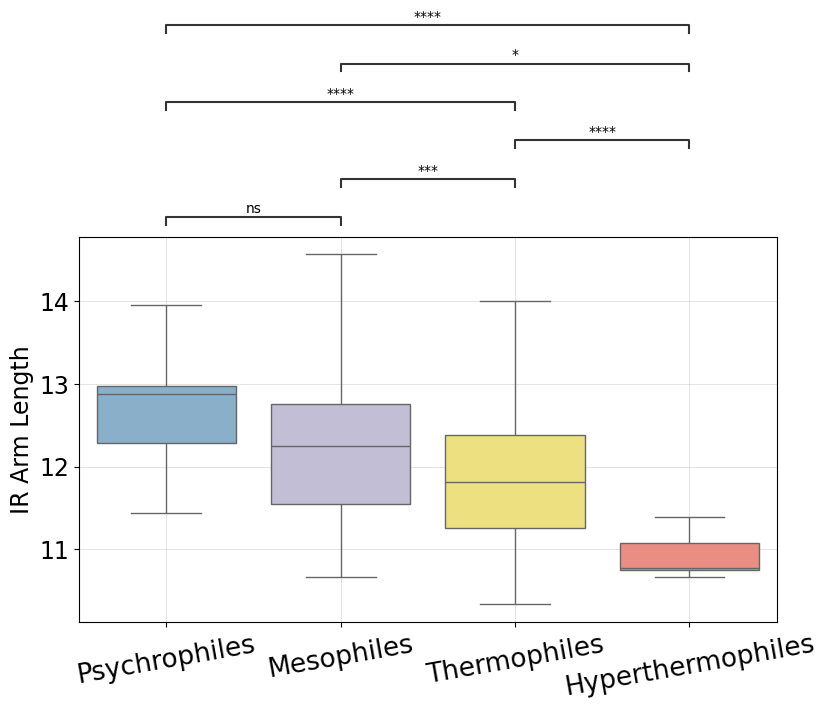

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

order = [
      "Psychrophiles",
      "Mesophiles",
      "Thermophiles",
      "Hyperthermophiles",
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
sns.boxplot(data=total_gc_content.to_pandas(), 
            x="thermo_class", 
            hue="thermo_class",
            y="avg_arm_size",
            showfliers=False,
            palette=palette,
            order=order,
            ax=ax)
    
pairs = [
         ("Psychrophiles", "Thermophiles"), 
         ("Psychrophiles", "Mesophiles"),
         ("Psychrophiles", "Hyperthermophiles"),
         ("Mesophiles", "Thermophiles"),
         ("Mesophiles", "Hyperthermophiles"),
         ("Thermophiles", "Hyperthermophiles")
]
        
annotator = Annotator(ax, 
                      pairs=pairs, 
                      data=total_gc_content.to_pandas(), 
                      x="thermo_class",
                      hue="thermo_class", 
                      y="avg_arm_size", 
                      order=order,
                      # hue_order=hue_order,
                     )
annotator.configure(test='t-test_ind', 
                    text_format='star',
                    fontsize=10,
                    line_offset=0.0,
                    comparisons_correction="fdr_bh",
                    loc='outside')
annotator.apply_and_annotate()
ax.axhline(1.0, linestyle='--', color='black', lw=1.5, zorder=4)
# ax.set_ylim(0.0, 0.8)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="x", labelsize=19, rotation=10)
ax.tick_params(axis="y", labelsize=17)
ax.yaxis.label.set_size(17)
ax.set_ylabel("IR Arm Length")
ax.set_xlabel('')
fig.savefig(f"{dest}/IR_average_arm_length_vs_thermo_class.png", bbox_inches='tight')

In [99]:
total_gc_content.head()

#assembly_accession,gc_arm,armLength,gc_percent,genome_size,family,order,Topt_ave,superkingdom,phylum,maximum_arm,avg_arm_size,gc_arm_perc,thermo_class,hairpin_gc_enrichment
str,i64,i64,f64,i64,str,str,f64,str,str,i64,f64,f64,str,f64
"""GCA_000008005.1""",6318,19337,0.355,5432652,"""Bacillaceae""","""Bacillales""",37.0,"""Bacteria""","""Firmicutes""",33,13.665724,0.326731,"""Mesophiles""",0.920369
"""GCA_000010565.1""",1161,2328,0.53,3025375,"""Peptococcaceae""","""Clostridiales""",55.0,"""Bacteria""","""Firmicutes""",22,11.085714,0.498711,"""Thermophiles""",0.940965
"""GCA_000013065.1""",6396,19842,0.355,5506207,"""Bacillaceae""","""Bacillales""",37.0,"""Bacteria""","""Firmicutes""",27,13.553279,0.322347,"""Mesophiles""",0.908018
"""GCA_000021225.1""",6401,19729,0.355,5599857,"""Bacillaceae""","""Bacillales""",37.0,"""Bacteria""","""Firmicutes""",27,13.439373,0.324446,"""Mesophiles""",0.913933
"""GCA_000026125.1""",2668,5467,0.545,3424307,"""Oxalobacteraceae""","""Burkholderiales""",25.0,"""Bacteria""","""Proteobacteria""",24,12.481735,0.488019,"""Mesophiles""",0.895448
